In [1]:
import numpy as np
import xarray as xr
import seaborn as sns

from scripts import extractBasin 

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


## Running the simulations

To run the different simulations, you will need to do the following in a terminal:

```bash
mpirun -np X python3 runModel.py -i input-escarpment.yml 
```

where X is the number of processors to use.

## Visualising the outputs

You can visualise the outputs of your simulations directly in Paraview. Below we also show how this could be extracted as netcdf grids and analysed in Python.



**Before running this notebook, make sure that you have extracted the nc-grids from your goSPL output folder.**

> This is done by running:

```python
python3 build_ncgrids.py -i input-escarpment.yml -o nc-escarpment -s 75
```

where:
+ `input-escarpment.yml`: the goSPL inputfile for a specific model
+ `nc-escarpment`: a specific folder where the new grids will be saved
+ `75`: a integer representing the number of time steps to process (usually set to the number of goSPL outputs)

This will create a sets of regular nc grids with goSPL outputs (`dataXXX.nc`)

### Extract a specific basin river profile

Load a netcdf grid from goSPL at a specific time step:

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_82713/1258337112.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


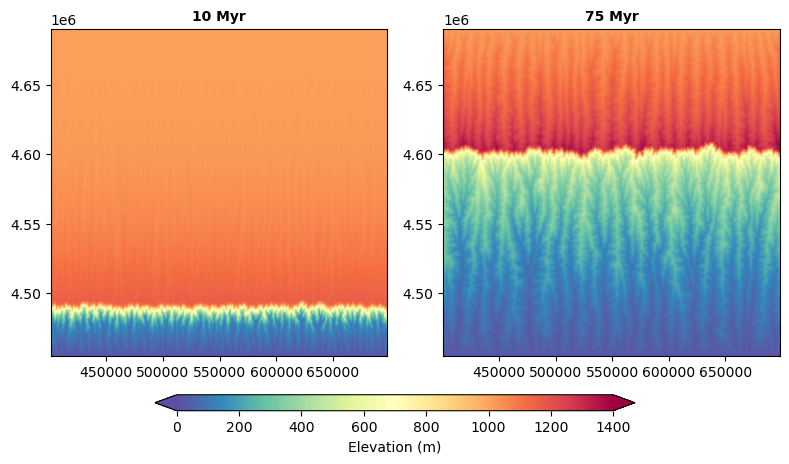

In [2]:
out_path = 'nc-escarpment/'
dataset1 = xr.open_dataset(out_path+'data10.nc')
dataset2 = xr.open_dataset(out_path+'data75.nc')

fig, ax = plt.subplots(1,2, figsize=(8,4))
im = dataset1.elevation.plot(ax=ax[0], add_labels=False, add_colorbar=False, vmin=0, vmax=1400, cmap='Spectral_r')
ax[0].set_title('10 Myr', fontsize=10, fontweight="bold")

dataset2.elevation.plot(ax=ax[1], add_labels=False, add_colorbar=False, vmin=0, vmax=1400, cmap='Spectral_r')
ax[1].set_title('75 Myr', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Elevation (m)')

plt.tight_layout()
plt.show()

Choose a point coordinate on a basin (`pt_x`, `pt_y`) and call the `getCatchment` function that return the river basin information.

The `fa_thres` is the flow accumulation threshold under which we stop looking from remaining streams as they are really small...

In [3]:
pt_x = 540000
pt_y = 4.3*1.e6
grid, branches, dist, branch_df = extractBasin.getCatchment(dataset2, pt_x, pt_y, fa_thres=25)

This function returns a list of branches (segments of the main streams of the river), that we can then visualise:

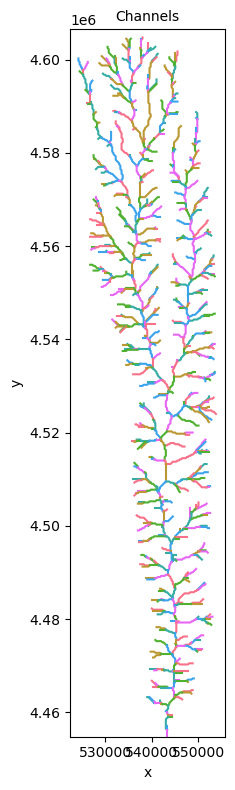

In [4]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8,8))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    

plt.xlabel('x')
plt.ylabel('y')
_ = plt.title('Channels', size=10)
plt.tight_layout()
plt.show()

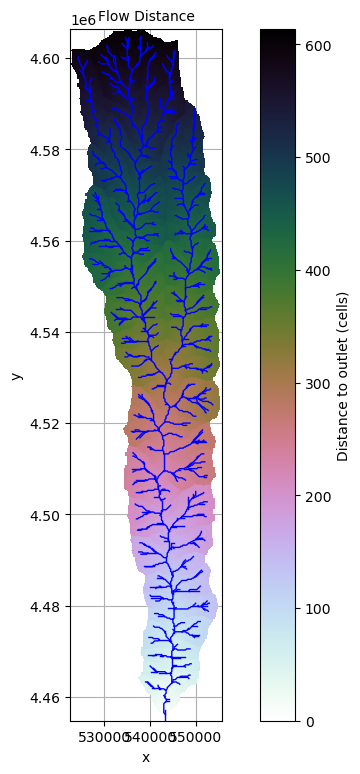

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)

im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1], c='b', lw=1)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Flow Distance', size=10)
plt.tight_layout()
plt.show()

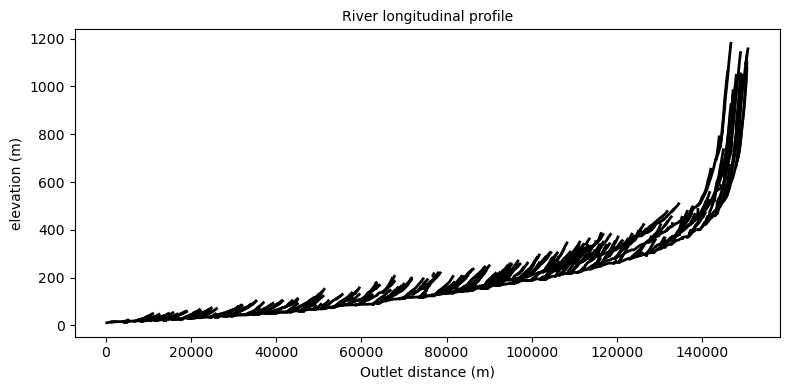

In [6]:
plt.figure(figsize=(8,4))
ax = plt.gca()

for b in range(len(branch_df)):
    br = branch_df[b]
    plt.plot(br.dist, br.z, lw=2, c='k')
    
plt.xlabel('Outlet distance (m)')
plt.ylabel('elevation (m)')
plt.title('River longitudinal profile', size=10)
plt.tight_layout()
plt.show()

### Escarpment retreat

In [7]:
meands = dataset2.mean(dim='x')
maxds = dataset2.max(dim='x')
minds = dataset2.min(dim='x')

escarpment_pos_mean = meands.elevation.where(meands.elevation==meands.elevation.max(), drop=True).squeeze().y.values
escarpment_pos_max = maxds.elevation.where(maxds.elevation==maxds.elevation.max(), drop=True).squeeze().y.values
escarpment_pos_min = minds.elevation.where(minds.elevation==minds.elevation.max(), drop=True).squeeze().y.values


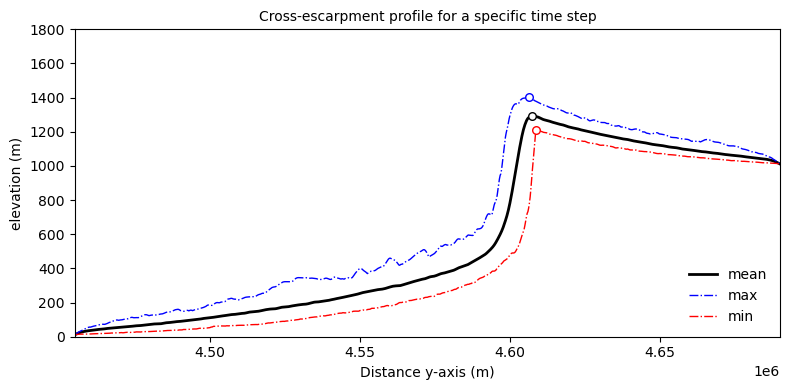

In [8]:

plt.figure(figsize=(8,4))
ax = plt.gca()

meands.elevation.plot(lw=2,c='k',label='mean')
maxds.elevation.plot(lw=1,c='b',ls='-.',label='max')
minds.elevation.plot(lw=1,c='r',ls='-.',label='min')

plt.scatter(escarpment_pos_mean,meands.elevation.max(),c='w',s=30,edgecolors='k',zorder=2)
plt.scatter(escarpment_pos_min,minds.elevation.max(),c='w',s=30,edgecolors='r',zorder=2)
plt.scatter(escarpment_pos_max,maxds.elevation.max(),c='w',s=30,edgecolors='b',zorder=2)

plt.xlabel('Distance y-axis (m)')
plt.ylabel('elevation (m)')
plt.title('Cross-escarpment profile for a specific time step', size=10)
plt.ylim(0,1800)
plt.xlim(dataset2.y.min(),dataset2.y.max())
plt.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()

To evaluate the escarpment evolution over time:

In [9]:
escpt_mean = []
escpt_max = []
escpt_min = []

escpt_pos_mean = []
escpt_pos_max = []
escpt_pos_min = []

for s in range(1,76):
    # Open netcdf data file for the considered time step
    dataset = xr.open_dataset(out_path+'data'+str(s)+'.nc')
    
    # Get escarpment longitudinal profile information
    meands = dataset.mean(dim='x')
    maxds = dataset.max(dim='x')
    minds = dataset.min(dim='x')
    escpt_mean.append(meands)
    escpt_max.append(maxds)
    escpt_min.append(minds)

    # Get escarpment position
    maxz_mean = meands.elevation.max().values
    maxz_min = minds.elevation.max().values
    maxz_max = maxds.elevation.max().values

    escarpment_pos_mean = meands.elevation.where(meands.elevation==maxz_mean, drop=True).squeeze().y.values
    escarpment_pos_max = maxds.elevation.where(maxds.elevation==maxz_max, drop=True).squeeze().y.values
    escarpment_pos_min = minds.elevation.where(minds.elevation==maxz_min, drop=True).squeeze().y.values
    
    escpt_pos_mean.append([escarpment_pos_mean,maxz_mean])
    escpt_pos_max.append([escarpment_pos_max,maxz_max])
    escpt_pos_min.append([escarpment_pos_min,maxz_min])
    

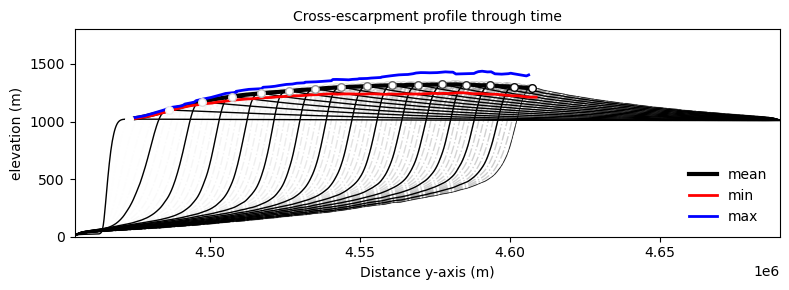

In [10]:
plt.figure(figsize=(8,3))
ax = plt.gca()

cmap = plt.get_cmap('gray_r', len(escpt_mean)+1) 
    
for k in range(0,len(escpt_mean)):
    meands = escpt_mean[k]
    escarpment_pos_mean = escpt_pos_mean[k]
    meands.elevation.plot(lw=1,ls='-.',c=cmap(k),alpha=0.2)
    plt.scatter(escarpment_pos_mean[0],escarpment_pos_mean[1],c='w',
                s=30,edgecolors=cmap(k),zorder=2,alpha=0.2)


for k in range(0,len(escpt_mean),5):
    meands = escpt_mean[k]
    escarpment_pos_mean = escpt_pos_mean[k]
    meands.elevation.plot(lw=1,c='k')
    plt.scatter(escarpment_pos_mean[0],escarpment_pos_mean[1],c='w',
                s=30,edgecolors=cmap(k),zorder=4)

k = 74
meands = escpt_mean[k]
escarpment_pos_mean = escpt_pos_mean[k]
meands.elevation.plot(lw=0.5,c='k')
plt.scatter(escarpment_pos_mean[0],escarpment_pos_mean[1],c='w',
            s=30,edgecolors=cmap(k),zorder=4)

val = np.asarray(escpt_pos_mean)
plt.plot(val[:,0],val[:,1],lw=3,c='k',label='mean')
val = np.asarray(escpt_pos_min)
plt.plot(val[:,0],val[:,1],lw=2,c='r',label='min')
val = np.asarray(escpt_pos_max)
plt.plot(val[1:,0],val[1:,1],lw=2,c='b',label='max')

plt.xlabel('Distance y-axis (m)')
plt.ylabel('elevation (m)')
plt.title('Cross-escarpment profile through time', size=10)
plt.ylim(0,1800)
plt.xlim(dataset.y.min(),dataset.y.max())
plt.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()

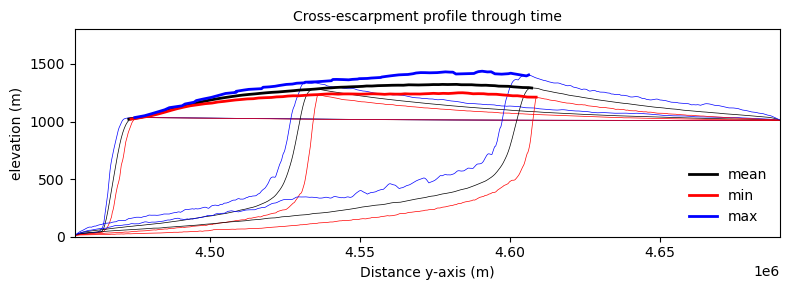

In [11]:
plt.figure(figsize=(8,3))
ax = plt.gca()


k = 1
escpt_mean[k].elevation.plot(lw=0.5,c='k')
escpt_max[k].elevation.plot(lw=0.5,c='b')
escpt_min[k].elevation.plot(lw=0.5,c='r')

k = 30
escpt_mean[k].elevation.plot(lw=0.5,c='k')
escpt_max[k].elevation.plot(lw=0.5,c='b')
escpt_min[k].elevation.plot(lw=0.5,c='r')

k = 74
escpt_mean[k].elevation.plot(lw=0.5,c='k')
escpt_max[k].elevation.plot(lw=0.5,c='b')
escpt_min[k].elevation.plot(lw=0.5,c='r')

val = np.asarray(escpt_pos_mean)
plt.plot(val[:,0],val[:,1],lw=2,c='k',label='mean')
val2 = np.asarray(escpt_pos_min)
plt.plot(val2[:,0],val2[:,1],lw=2,c='r',label='min')
val3 = np.asarray(escpt_pos_max)
plt.plot(val3[1:,0],val3[1:,1],lw=2,c='b',label='max')


plt.xlabel('Distance y-axis (m)')
plt.ylabel('elevation (m)')
plt.title('Cross-escarpment profile through time', size=10)
plt.ylim(0,1800)
plt.xlim(dataset.y.min(),dataset.y.max())
plt.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()

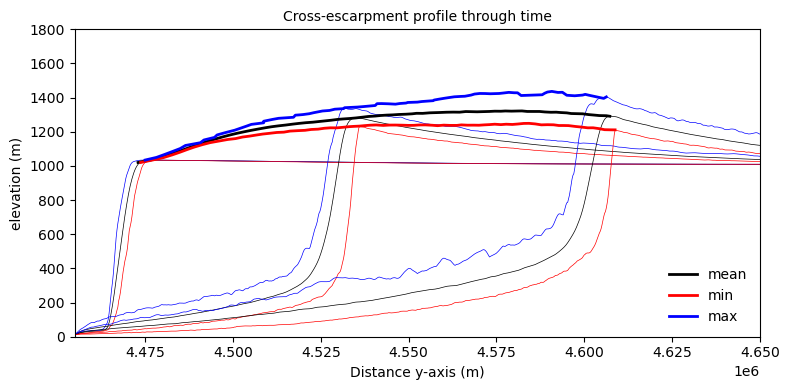

In [12]:
plt.figure(figsize=(8,4))
ax = plt.gca()

k = 1
escpt_mean[k].elevation.plot(lw=0.5,c='k')
escpt_max[k].elevation.plot(lw=0.5,c='b')
escpt_min[k].elevation.plot(lw=0.5,c='r')

k = 30
escpt_mean[k].elevation.plot(lw=0.5,c='k')
escpt_max[k].elevation.plot(lw=0.5,c='b')
escpt_min[k].elevation.plot(lw=0.5,c='r')

k = 74
escpt_mean[k].elevation.plot(lw=0.5,c='k')
escpt_max[k].elevation.plot(lw=0.5,c='b')
escpt_min[k].elevation.plot(lw=0.5,c='r')

val = np.asarray(escpt_pos_mean)
plt.plot(val[:,0],val[:,1],lw=2,c='k',label='mean')
val2 = np.asarray(escpt_pos_min)
plt.plot(val2[:,0],val2[:,1],lw=2,c='r',label='min')
val3 = np.asarray(escpt_pos_max)
plt.plot(val3[1:,0],val3[1:,1],lw=2,c='b',label='max')


plt.xlabel('Distance y-axis (m)')
plt.ylabel('elevation (m)')
plt.title('Cross-escarpment profile through time', size=10)
plt.ylim(0,1800)
plt.xlim(dataset.y.min(),4.65*1.e6)
plt.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()

### Flexural response

In [13]:
flex_mean = []
flex_max = []
flex_min = []

for s in range(1,76):
    # Open netcdf data file for the considered time step
    dataset = xr.open_dataset(out_path+'data'+str(s)+'.nc')
    
    # Get escarpment longitudinal profile information
    meands = dataset.mean(dim='x')
    maxds = dataset.max(dim='x')
    minds = dataset.min(dim='x')
    flex_mean.append(meands)
    flex_max.append(maxds)
    flex_min.append(minds)

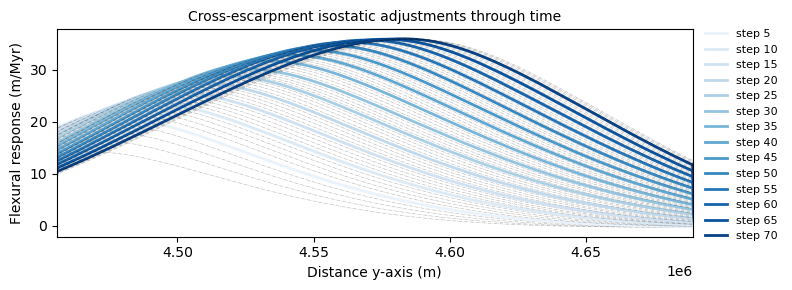

In [15]:
plt.figure(figsize=(8,3))
ax = plt.gca()

cmap = plt.get_cmap('Blues', 76) 

for k in range(1,75):
    val = flex_mean[k].flex-flex_mean[k-1].flex
    val.plot(lw=0.4,ls='-.',c='k',alpha=0.3)
    if k%5 == 0:
        val.plot(lw=2,c=cmap(k),label='step '+str(k))

plt.xlabel('Distance y-axis (m)')
plt.ylabel('Flexural response (m/Myr)')
plt.title('Cross-escarpment isostatic adjustments through time', size=10)
plt.xlim(dataset.y.min()+750,dataset.y.max()-750)
plt.legend(frameon=False, loc="upper right",bbox_to_anchor=(1.15, 1.05), fontsize=8)
plt.tight_layout()
plt.show()